# SemEval 2024 Task 2: Safe Biomedical Natural Language Inference for Clinical Trials

----------------

In [1]:
# Könyvtárak telepítése (ha még nem telepítetted)
# !pip install --quiet transformers datasets torch scikit-learn pandas tqdm
# !pip install -U transformers

# Adatok klónozása és kicsomagolása (egyszeri lépés)
# !git clone https://github.com/ai-systems/Task-2-SemEval-2024.git

# !unzip -q /content/Task-2-SemEval-2024/training_data.zip -d /content/Task-2-SemEval-2024/

In [2]:
import transformers
print(transformers.__version__)

c:\Egyetem\Számítógépes szemantika\Projekt\SemEval_2024_Task-2_SafeBiomedicalNaturalLanguageInferenceForClinicalTrials\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.52.4


In [3]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

import torch
import accelerate
import transformers

print(torch.__version__)
print(accelerate.__version__)
print(transformers.__version__)

CUDA available: True
GPU: NVIDIA GeForce RTX 2070
2.7.1+cu118
1.7.0
4.52.4


In [4]:
import os
import json
import pandas as pd
from tqdm import tqdm
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer
import torch

# DATA_DIR = "/content/Task-2-SemEval-2024"
DATA_DIR = "Task-2-SemEval-2024"
TRAIN_PATH = f"{DATA_DIR}/train.json"
DEV_PATH = f"{DATA_DIR}/dev.json"
TEST_PATH = f"{DATA_DIR}/test.json"
CTRS_DIR = f"{DATA_DIR}/CT json"  # CTR fájlok könyvtára
# DEV_PATH = "/content/Task-2-SemEval-2024/dev.json"
DEV_PATH = "Task-2-SemEval-2024/dev.json"

# Modell neve (cserélhető pl. 'emilyalsentzer/Bio_ClinicalBERT')
MODEL_NAME = "bert-base-uncased"
# MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"
# MODEL_NAME = "dmis-lab/biobert-base-cased-v1.1"
# MODEL_NAME = "microsoft/deberta-v3-base"
# MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
# MODEL_NAME = "bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12"


# Kétosztályos címkézés beállítása
label2id = {"Entailment": 0, "Contradiction": 1}
id2label = {0: "Entailment", 1: "Contradiction"}

In [5]:
def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

# Betöltés
train_dict = load_json(TRAIN_PATH)
dev_dict = load_json(DEV_PATH)
test_dict = load_json(TEST_PATH)

# Átalakítás lista formátumra, ID-k hozzáadása
def dict_to_list(data_dict):
    data_list = []
    for ex_id, ex in data_dict.items():
        ex["id"] = ex_id
        data_list.append(ex)
    return data_list

train_data = dict_to_list(train_dict)
dev_data = dict_to_list(dev_dict)
test_data = dict_to_list(test_dict)

In [6]:
def process_examples(data_list, ctr_dir):
    processed = []
    for ex in tqdm(data_list):
        ctr_id = ex["Primary_id"]
        section = ex["Section_id"]
        hypothesis = ex["Statement"]
        label = ex.get("Label")  # tesztnél nem biztos, hogy van

        ctr_file = os.path.join(ctr_dir, f"{ctr_id}.json")
        if not os.path.isfile(ctr_file):
            print(f"WARNING: CTR file not found: {ctr_file}")
            continue

        with open(ctr_file, "r", encoding="utf-8") as f:
            ctr = json.load(f)

        # A szekció neve a CTR-ben pontos egyezést igényel
        if section not in ctr:
            print(f"WARNING: section '{section}' not found in CTR {ctr_id}")
            continue

        section_content = ctr[section]
        premise_text = "\n".join(section_content) if isinstance(section_content, list) else str(section_content)

        input_text = f"[{section}] {premise_text.strip()}\nHypothesis: {hypothesis.strip()}"

        processed.append({
            "id": ex["id"],
            "ctr_id": ctr_id,
            "section": section,
            "hypothesis": hypothesis,
            "label": label,
            "input_text": input_text
        })
    return pd.DataFrame(processed)

# Feldolgozás
df_train = process_examples(train_data, CTRS_DIR)
df_dev = process_examples(dev_data, CTRS_DIR)
df_test = process_examples(test_data, CTRS_DIR)

100%|██████████| 5500/5500 [00:02<00:00, 1959.78it/s]


In [7]:
# Mentés CSV-be, ha szükséges
df_train.to_csv("processed_train.csv", index=False)
df_dev.to_csv("processed_dev.csv", index=False)
df_test.to_csv("processed_test.csv", index=False)

# HuggingFace Dataset objektumok létrehozása
dataset_train = Dataset.from_pandas(df_train)
dataset_dev = Dataset.from_pandas(df_dev)
dataset_test = Dataset.from_pandas(df_test)

In [8]:
# Tokenizer és modell betöltése
# --- Ezt módosítjuk kétosztályosra ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)  # 2 label: Entailment, Contradiction

# GPU beállítása (ha elérhető)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
# Címkék számokká konvertálása
# --- Ezt módosítjuk kétosztályosra ---
def encode_labels(example):
    example["label"] = label2id[example["label"]]
    return example

dataset_train = dataset_train.map(encode_labels)

Map: 100%|██████████| 1700/1700 [00:00<00:00, 5691.92 examples/s]


In [10]:
def tokenize_function(example):
    return tokenizer(
        example["input_text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

tokenized_train = dataset_train.map(tokenize_function, batched=True)

Map: 100%|██████████| 1700/1700 [00:01<00:00, 1667.45 examples/s]


In [11]:
tokenized_train = tokenized_train.train_test_split(test_size=0.1)
train_dataset = tokenized_train["train"]
eval_dataset = tokenized_train["test"]

In [12]:
# dev_dict betöltése
with open(DEV_PATH, "r", encoding="utf-8") as f:
    dev_dict = json.load(f)

# Átalakítás listává
dev_data = []
for ex_id, ex in dev_dict.items():
    ex["id"] = ex_id
    dev_data.append(ex)

In [13]:
# dev_dict = json.load(...) és process_examples(...) a dev-re is
df_dev = process_examples(dev_data, CTRS_DIR)
dataset_dev = Dataset.from_pandas(df_dev)
dataset_dev = dataset_dev.map(encode_labels)
tokenized_dev = dataset_dev.map(tokenize_function, batched=True)

train_dataset = tokenized_train
eval_dataset = tokenized_dev

Map: 100%|██████████| 200/200 [00:00<00:00, 2122.51 examples/s]


In [14]:
training_args = TrainingArguments(
    output_dir="/content/bert-semeval-results",
    eval_strategy="epoch",  # ← ***
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="/content/logs",
    logging_steps=50,
    report_to=[]  # kikapcsolja az összes külső riportáló rendszert (beleértve a wandb-t),
)

In [15]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

In [16]:
train_dataset = tokenized_train["train"]
# eval_dataset = tokenized_train["test"]
eval_dataset = tokenized_dev

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

C:\Users\2314l\AppData\Local\Temp\ipykernel_19828\150962918.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.708900,0.700653,0.500000,0.333333
2,0.712600,0.692414,0.500000,0.350312
3,0.700400,0.685582,0.545000,0.544077
4,0.695800,0.683108,0.565000,0.529412
5,0.699700,0.681336,0.565000,0.510011
6,0.681100,0.668308,0.585000,0.562870
7,0.655000,0.661219,0.580000,0.564270
8,0.623900,0.669293,0.555000,0.554900
9,0.630800,0.666500,0.580000,0.579622
10,0.621300,0.667985,0.590000,0.577798


TrainOutput(global_step=1920, training_loss=0.6686380167802175, metrics={'train_runtime': 1341.4654, 'train_samples_per_second': 11.405, 'train_steps_per_second': 1.431, 'total_flos': 4025599147008000.0, 'train_loss': 0.6686380167802175, 'epoch': 10.0})

In [17]:
# Tokenizált tesztadat újragenerálása, ha szükséges
tokenized_test = dataset_test.map(tokenize_function, batched=True)

# A label mező eltávolítása (mivel a teszt set nem tartalmaz címkéket)
tokenized_test = tokenized_test.remove_columns("label")

Map: 100%|██████████| 5500/5500 [00:02<00:00, 1906.65 examples/s]


In [18]:
predictions = trainer.predict(tokenized_test)
predicted_labels = np.argmax(predictions.predictions, axis=1)
predicted_classes = [id2label[p] for p in predicted_labels]

# Mentés CSV-be
df_preds = df_test.copy()
df_preds["predicted_label"] = predicted_classes
df_preds[["id", "predicted_label"]].to_csv("test_predictions.csv", index=False)

In [19]:
trainer.evaluate(eval_dataset=tokenized_dev)

{'eval_loss': 0.6679853796958923,
 'eval_accuracy': 0.59,
 'eval_f1_macro': 0.5777983729790959,
 'eval_runtime': 5.1843,
 'eval_samples_per_second': 38.578,
 'eval_steps_per_second': 4.822,
 'epoch': 10.0}

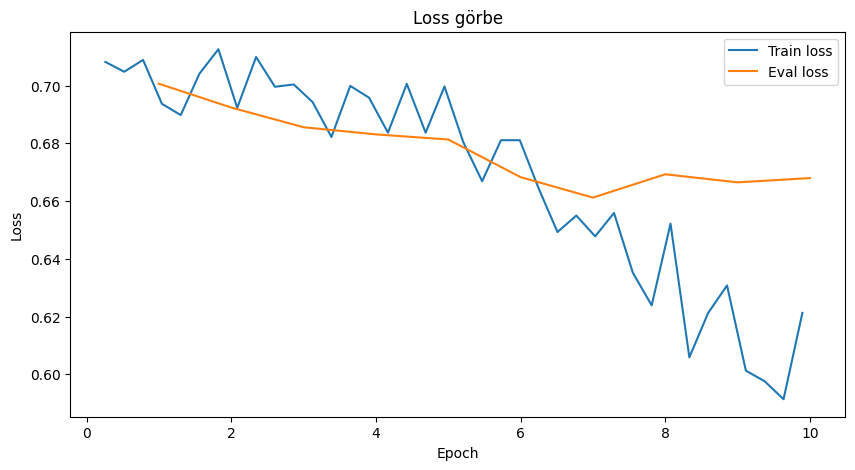

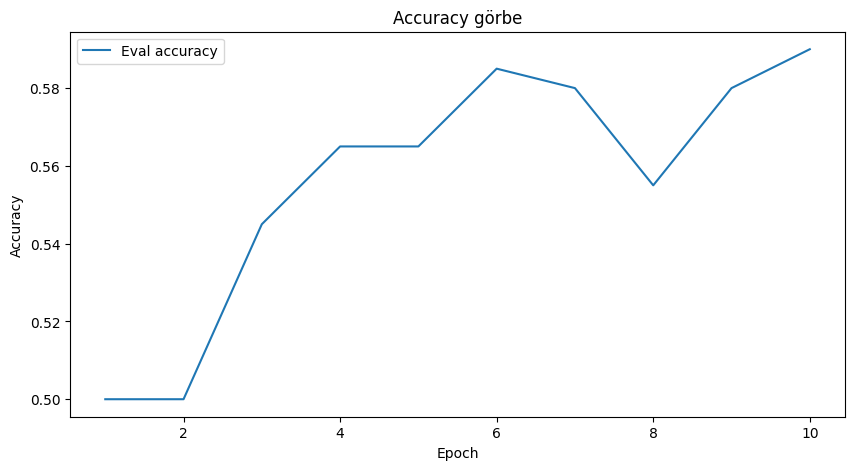

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# A Trainer log fájl elérési útja
log_path = "./content/logs/events.out.tfevents.*"  # vagy a pontos logfájl, ha tudod

# Alternatív: ha a Trainer history-t elmented, pl. trainer.state.log_history
history = trainer.state.log_history

# Loss és accuracy kigyűjtése
train_loss = [x["loss"] for x in history if "loss" in x and "epoch" in x]
eval_loss = [x["eval_loss"] for x in history if "eval_loss" in x]
eval_acc = [x["eval_accuracy"] for x in history if "eval_accuracy" in x]
epochs = [x["epoch"] for x in history if "loss" in x and "epoch" in x]
eval_epochs = [x["epoch"] for x in history if "eval_loss" in x]

plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss, label="Train loss")
plt.plot(eval_epochs, eval_loss, label="Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss görbe")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(eval_epochs, eval_acc, label="Eval accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy görbe")
plt.show()

In [ ]:
ne fuss le

save_dir = "Results/bert-base-uncased_2025-06-08_optimized"
os.makedirs(save_dir, exist_ok=True)

# Modell és tokenizer mentése
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

# Trainer log_history mentése
import json
with open(os.path.join(save_dir, "log_history.json"), "w", encoding="utf-8") as f:
    json.dump(trainer.state.log_history, f, ensure_ascii=False, indent=2)

# Loss/accuracy görbék mentése képként
import matplotlib.pyplot as plt

history = trainer.state.log_history
train_loss = [x["loss"] for x in history if "loss" in x and "epoch" in x]
eval_loss = [x["eval_loss"] for x in history if "eval_loss" in x]
eval_acc = [x["eval_accuracy"] for x in history if "eval_accuracy" in x]
epochs = [x["epoch"] for x in history if "loss" in x and "epoch" in x]
eval_epochs = [x["epoch"] for x in history if "eval_loss" in x]

plt.figure(figsize=(10,5))
plt.plot(epochs, train_loss, label="Train loss")
plt.plot(eval_epochs, eval_loss, label="Eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss görbe")
plt.savefig(os.path.join(save_dir, "loss_curve.png"))
plt.close()

plt.figure(figsize=(10,5))
plt.plot(eval_epochs, eval_acc, label="Eval accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy görbe")
plt.savefig(os.path.join(save_dir, "accuracy_curve.png"))
plt.close()

# Predikciók mentése (ha van)
if "predicted_classes" in locals():
    df_preds.to_csv(os.path.join(save_dir, "test_predictions.csv"), index=False)


In [ ]:
ne fuss le

from transformers import AutoModelForSequenceClassification, AutoTokenizer

load_dir = "Results/bert-base-uncased_2025-06-08_optimized"
model = AutoModelForSequenceClassification.from_pretrained(load_dir)
tokenizer = AutoTokenizer.from_pretrained(load_dir)